<a href="https://colab.research.google.com/github/1kaiser/Snow-cover-area-estimation/blob/main/ECOSTRESS_data_processing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!wget https://github.com/1kaiser/Snow-cover-area-estimation/releases/download/v1/ECOSTRESS.zip
!unzip -o /content/ECOSTRESS.zip -d /content/files 

In [3]:
image_dir = r'/content/files'

#############################################################################
prefix = "ECO2LSTE.001_SDS_"
bandend = ["LST", "PWV", "b03", "b04", "b05", "b06", "b07", "day_of_year", "qc_500m", "raz", "state_500m", "szen", "vzen"]
DayOY = "_doy\[0-9]+_aid0001"
fileExt = r'.tif'
expression_b1 = prefix+bandend[0]

expression_b2 = prefix+bandend[1]



temp_dir = r'/content/'
import os

imgs_list_b1 = [f for f in os.listdir(image_dir) if f.__contains__(expression_b1)]

imgs_list_b1.sort(reverse=True) 

                    #<<<< to start file streaming from the last date 2022 >> 2021 >> 2020 ....

imgs_path_b1 = [os.path.join(image_dir, i) for i in imgs_list_b1 if i != 'outputs']
print(len(imgs_path_b1))

354


In [ ]:
imgs_path_b1

In [ ]:
!wget https://github.com/1kaiser/ICESAT2/releases/download/1/DEM.tif 
!wget https://github.com/1kaiser/ICESAT2/releases/download/1/SLOPE.tif
!wget https://github.com/1kaiser/ICESAT2/releases/download/1/ASPECT.tif

In [ ]:
!pip install rasterio

In [48]:
from osgeo import gdal, osr

def transform_and_reshape_raster(raster_file, dem_file, output_file):
    # Open the DEM file
    dem_dataset = gdal.Open(dem_file, gdal.GA_ReadOnly)
    if dem_dataset is None:
        print("Failed to open the DEM file.")
        return

    # Get the DEM projection and geotransform information
    dem_projection = dem_dataset.GetProjection()
    dem_geotransform = dem_dataset.GetGeoTransform()

    # Open the raster file
    raster_dataset = gdal.Open(raster_file, gdal.GA_ReadOnly)
    if raster_dataset is None:
        print("Failed to open the raster file.")
        return

    # Get the raster projection and geotransform information
    raster_projection = raster_dataset.GetProjection()
    raster_geotransform = raster_dataset.GetGeoTransform()

    # Create a new dataset for the output file
    driver = gdal.GetDriverByName('GTiff')
    output_dataset = driver.Create(output_file, dem_dataset.RasterXSize, dem_dataset.RasterYSize, 1, gdal.GDT_Float32)

    # Set the output dataset's projection and geotransform
    output_dataset.SetProjection(dem_projection)
    output_dataset.SetGeoTransform(dem_geotransform)

    # Reproject and reshape the raster
    gdal.ReprojectImage(raster_dataset, output_dataset, raster_projection, dem_projection, gdal.GRA_NearestNeighbour)

    # Close the datasets
    dem_dataset = None
    raster_dataset = None
    output_dataset = None

    print("Raster transformation and reshaping completed.")

# Usage example
raster_file = '/content/files/ECO2LSTE.001_SDS_LST_doy2018219075901_aid0001.tif'
dem_file = '/content/DEM.tif'
output_file = '/content/output_reprojected.tif'

transform_and_reshape_raster(raster_file, dem_file, output_file)


Raster transformation and reshaping completed.


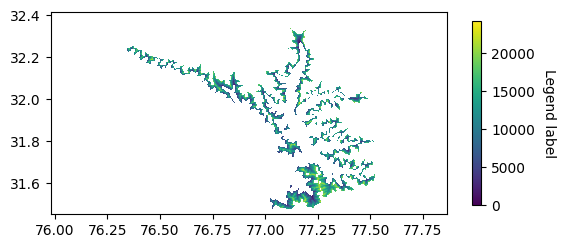

Minimum: 6738
Maximum: 24325
Mean: 14066.0086914008
Standard Deviation: 424.03853597574795


In [42]:
import rasterio
import numpy as np
import matplotlib.pyplot as plt

# Open the DEM raster file
dem_in = rasterio.open('/content/DEM.tif')
dem_data = dem_in.read(1, masked=True)

# Set the range values to select
min_range = 2000
max_range = 3000

# Apply the range condition to the DEM data
dem_data_range = np.where((dem_data >= min_range) & (dem_data <= max_range), dem_data, np.nan)

# Open the raster file
src = rasterio.open(imgs_path_b1[4])
data = src.read(1, masked=True)

left, bottom, right, top = src.bounds

# Calculate the statistics of the data
min_val = np.min(data)
max_val = np.max(data)
mean_val = np.mean(data)
std_val = np.std(data)

# Create a plot
fig, ax = plt.subplots()

# Show the raster on the plot
ax.imshow(dem_data_range, extent=[left, right, bottom, top])
# im = ax.imshow(data, extent=[left, right, bottom, top])

# Add a legend
cbar = plt.colorbar(im, ax=ax, shrink=0.5)

# Set the label for the legend
cbar.ax.set_ylabel('Legend label', rotation=270, labelpad=15)

# Show the plot
plt.show()

# Print the statistics
print("Minimum:", min_val)
print("Maximum:", max_val)
print("Mean:", mean_val)
print("Standard Deviation:", std_val)


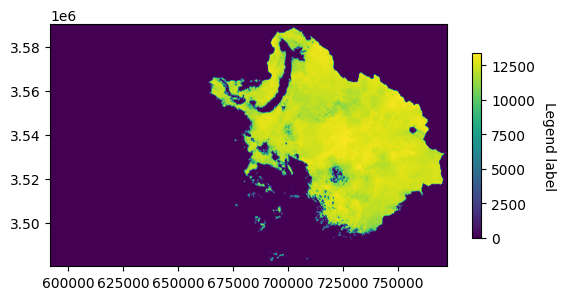

Raster Statistics:
Minimum: 0.0
Maximum: 13408.0
Mean: 2967.412
Standard Deviation: 5257.5747

Combined Statistics:
Combined Minimum: 0.0
Combined Maximum: 13408.0
Combined Mean: 2921.0269
Combined Standard Deviation: 4996.808


In [51]:
import rasterio
import numpy as np
import matplotlib.pyplot as plt

# Open the DEM raster file
dem_in = rasterio.open('/content/DEM.tif')
dem_data = dem_in.read(1, masked=True)

# Set the range values to select
min_range = 2000
max_range = 3000

# Apply the range condition to the DEM data
dem_data_range = np.where((dem_data >= min_range) & (dem_data <= max_range), dem_data, np.nan)

# Open the raster file (replace 'path_to_raster_file' with the actual file path)
src = rasterio.open('/content/output_reprojected.tif')
data = src.read(1, masked=True)

left, bottom, right, top = dem_in.bounds

# Calculate the statistics of the data
min_val = np.nanmin(data)
max_val = np.nanmax(data)
mean_val = np.nanmean(data)
std_val = np.nanstd(data)

# Calculate the statistics of the union of data and dem_data_range
combined_data = np.concatenate([data.flatten(), dem_data_range.flatten()])
combined_min_val = np.nanmin(combined_data)
combined_max_val = np.nanmax(combined_data)
combined_mean_val = np.nanmean(combined_data)
combined_std_val = np.nanstd(combined_data)

# Create a plot
fig, ax = plt.subplots()

# Show the raster on the plot

ax.imshow(dem_data_range, extent=[left, right, bottom, top])
im = ax.imshow(data, extent=[left, right, bottom, top])
# Add a legend
cbar = plt.colorbar(im, ax=ax, shrink=0.5)

# Set the label for the legend
cbar.ax.set_ylabel('Legend label', rotation=270, labelpad=15)

# Show the plot
plt.show()

# Print the statistics
print("Raster Statistics:")
print("Minimum:", min_val)
print("Maximum:", max_val)
print("Mean:", mean_val)
print("Standard Deviation:", std_val)

print("\nCombined Statistics:")
print("Combined Minimum:", combined_min_val)
print("Combined Maximum:", combined_max_val)
print("Combined Mean:", combined_mean_val)
print("Combined Standard Deviation:", combined_std_val)
